In [1]:
## Importing packages

library(tidyverse) # metapackage with lots of helpful functions
library(png) # package that can be used to read png image files in a simple format
library(caret)
library(glmnet)
library(doMC)
library(dplyr)

## Reading in files
list.files(path = "../input/")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-1

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel



[1] "facial-expressions-bda-2021"

In [2]:
# Show the availabe directories
dirs = dir("../input", pattern="[^g]$", recursive=TRUE, include.dirs = TRUE, full.names = TRUE)
dirs

[1] "../input/facial-expressions-bda-2021"                     
[2] "../input/facial-expressions-bda-2021/ckplus"              
[3] "../input/facial-expressions-bda-2021/ckplus/test"         
[4] "../input/facial-expressions-bda-2021/ckplus/train"        
[5] "../input/facial-expressions-bda-2021/ckplus/train/anger"  
[6] "../input/facial-expressions-bda-2021/ckplus/train/disgust"
[7] "../input/facial-expressions-bda-2021/ckplus/train/happy"  
[8] "../input/facial-expressions-bda-2021/ckplus/train/sadness"

In [3]:
# Get all image files: file names ending ".png" 
anger   = dir(grep("anger",   dirs, value = TRUE), pattern = "png$", full.names = TRUE)
disgust = dir(grep("disgust", dirs, value = TRUE), pattern = "png$", full.names = TRUE)
happy   = dir(grep("happy",   dirs, value = TRUE), pattern = "png$", full.names = TRUE)
sad     = dir(grep("sad",     dirs, value = TRUE), pattern = "png$", full.names = TRUE)
test_im = dir(grep("test",    dirs, value = TRUE), pattern = "png$", full.names = TRUE)

str(anger)
str(disgust)
str(happy)
str(sad)
str(test_im)

 chr [1:570] "../input/facial-expressions-bda-2021/ckplus/train/anger/S010_004_00000018a.png" ...
 chr [1:744] "../input/facial-expressions-bda-2021/ckplus/train/disgust/S005_001_00000009a.png" ...
 chr [1:870] "../input/facial-expressions-bda-2021/ckplus/train/happy/S010_006_00000013a.png" ...
 chr [1:354] "../input/facial-expressions-bda-2021/ckplus/train/sadness/S011_002_00000020a.png" ...
 chr [1:1080] "../input/facial-expressions-bda-2021/ckplus/test/S010_004_00000017a.png" ...


The pictures (video stills) show faces that were captured while more or less spontaneously expressing an emotion. Some of the images are repeated, but then shifted, rotated, or both. Not all are easy to classify:

In [4]:
ok = file.copy(  happy[60], "happy.png", overwrite = TRUE)
ok = file.copy(    sad[61],   "sad.png", overwrite = TRUE)
ok = file.copy(  anger[61], "anger.png", overwrite = TRUE)
ok = file.copy(disgust[61], "disgust.png", overwrite = TRUE)
IRdisplay::display_html('<img src="happy.png" width="200" style="float:left" /><img src="sad.png" width="200" style="float:left" /><img src="anger.png" width="200" style="float:left" /><img src="disgust.png" width="200" style="float:left" />')

Clearly the first is a happy face, but is the second a sad face, an angry face, or both?

# Data considerations

It's not difficult to find out how the data were collected. This is an important question to answer about any data set you use in a machine learning project because it will determine to what new data your model will generalize.

Answer the 3 most important questions for any ML project:

1. Where do the data come from? (To which population will results generalize?)
    - The data come from CK+ data base.
2. What are candidate machine learning methods? (models? features?)
    - Models: Prediction Tree, Ridge regression, Lasso regression, KNN, KNNS LDA, QDA,SVM
    - Features: Raw Pixels, FreySlateFeatures, Hog Features
3. What is the Bayes' error bound? (Any guestimate from scientific literature or web resources?)
    - See section below about the Bayes bound per facial expression



# Bayes bound

To have an idea of a lower bound on the Bayes bound (i.e., the minimum accuracy that should be achievable). The best 'machine' we have at hand to recognize emotion from facial expression in the human brain. How often do human judges get it correct? In a study by Mollahosseini et al. (2018) an estimate for human classification inter-rater agreement was obtained for 11 emotions. For the four included in this data set they are:


| disgust  |  anger  |  happy  |  sad  |
|---------:|--------:|--------:|-------|
|  67.6%   | 62.3%   | 79.6%   | 69.7% |


Keep this in mind when evaluating the performance of the classifiers that you'll train.

As always, it's handy to evaluate how the algorithm does on the training set: If the training set is not classified accurately, how can you expect the test set to do any better. This obvious fact is often overlooked—surprisingly.

# Import data

When working with image data, you often have many more Gigabytes of raw data than you have RAM memory available. Therefore, it is often not possible to work with all data "in memory". Resizing images often helps, but may cause loss of information.

The images for this competition are

- gray scale, so we need only one *color channel* 
- are only 48 by 48 pixels

Furthermore there are only 2538 pictures in the training set. Therefore, we are lucky enough to be able to retain all images in RAM, and don't have to do "special stuff" to handle reading in image files while fitting a model.

Reading in images pixelwise is easiest: We simply store each image as a long vector of pixel intensities, row by row. Also we will need a vector that contains the emotion label for each of the images.

In [5]:
# Combine all filenames into a single vector
train_image_files = c(anger, happy, sad, disgust)

# Read in the images as pixel values (discarding color channels)
X_train = sapply(train_image_files, function(nm) c(readPNG(nm)[,,1])) %>% t() 
y = c(rep("anger", length(anger)), rep("happy", length(happy)), rep("sad", length(sad)), rep("disgust", length(disgust)))

X_test = sapply(test_im, function(nm) c(readPNG(nm)[,,1])) %>% t() 


# Change row and column names of X to something more managable
rownames(X_train)      = gsub(".+train/", "", rownames(X_train))
rownames(X_test) = gsub(".+test/",  "", rownames(X_test))

colnames(X_train) = colnames(X_test) = paste("p",1:ncol(X_train), sep="")

In [6]:
# Check result (are X, X_test, and y what we expect)
X_train[1:6,20:23] %>% print
table(y)
                
X_test[1:6,20:23] %>% print

                                    p20        p21        p22        p23
anger/S010_004_00000018a.png 0.58039216 0.60784314 0.70196078 0.85882353
anger/S010_004_00000018b.png 0.02745098 0.02745098 0.04313725 0.07450980
anger/S010_004_00000018c.png 0.03529412 0.03137255 0.02745098 0.01960784
anger/S010_004_00000018d.png 0.03921569 0.03137255 0.03137255 0.02745098
anger/S010_004_00000018e.png 1.00000000 1.00000000 1.00000000 1.00000000
anger/S010_004_00000018f.png 1.00000000 1.00000000 1.00000000 1.00000000


y
  anger disgust   happy     sad 
    570     744     870     354 

                              p20        p21        p22        p23
S010_004_00000017a.png 0.77647059 0.81960784 0.89803922 0.98039216
S010_004_00000017b.png 0.46666667 0.52549020 0.63529412 0.74901961
S010_004_00000017c.png 0.25490196 0.34509804 0.49803922 0.67450980
S010_004_00000017d.png 0.04313725 0.03529412 0.03529412 0.02745098
S010_004_00000017e.png 0.03921569 0.03137255 0.03137255 0.02745098
S010_004_00000017f.png 0.07058824 0.10588235 0.14509804 0.24705882


# Helper functions

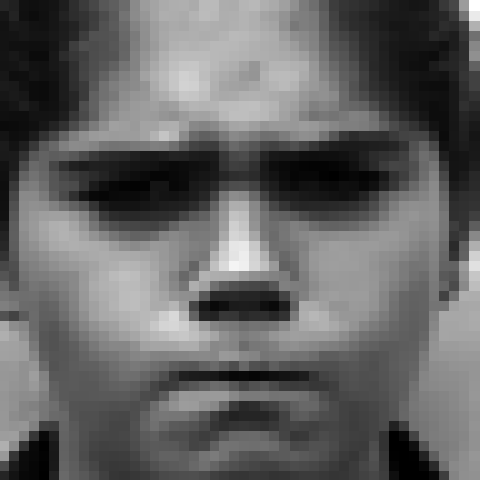

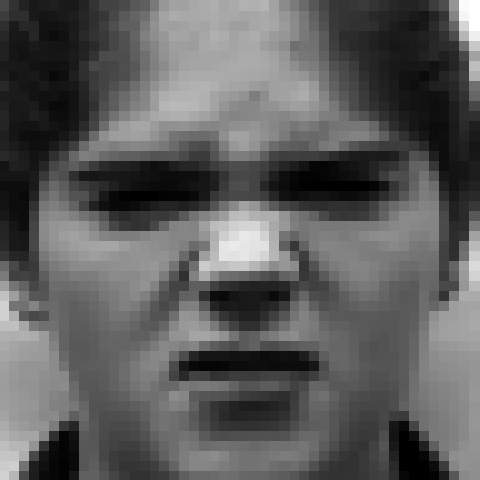

In [7]:
# Visualization utility function
as_image = function(x, nr = sqrt(length(x))) {
    opar = par(mar = rep(0, 4)); 
    on.exit(par(opar)); 
    image(t(matrix(x, nr))[, nr:1], col = gray(0:255 / 255), axes = F)
}

options(repr.plot.width=4, repr.plot.height=4)
as_image(X_train[13,])
as_image(X_test[13,])

In [8]:
# Input: a matrix with pixels of one image per row
# Output: a list of pixel matrices, one image per matrix
format_matrices = function(image_matrix, col = 48, row = 48) {
  
  image_pixels = list()
  
  for(i in 1:nrow(image_matrix)) {
    
    # extract pixel matrix for each image
    image_pixels[[i]] = image_matrix[i, ] %>% matrix(ncol = col, nrow = row) 
  }
  return(image_pixels)
}

dim(format_matrices(X_train)[[1]])

[1] 48 48

# Features

# Histogram features from edges

Histogram features work best on edges. How can you detect edges? To answer that question we have to consider what an edge is: An edge is a rapid change in pixel intensities, so if we compute the difference between two consecutive pixels, and check if it is larger than a certain threshold, we can find the pixels that are at the edge of an abrupt intensity change. In principle this can be done in any possible direction (north, south, west, east, north-west, south-west, etc.), but it turns out that it is enough to do it in only two directions: north and west (or south and east for that matter). These give horizontal and vertical edges respectively. By computing differences in both north and west direction consecutively we filter out pixels that are part of a diagonal edge. 

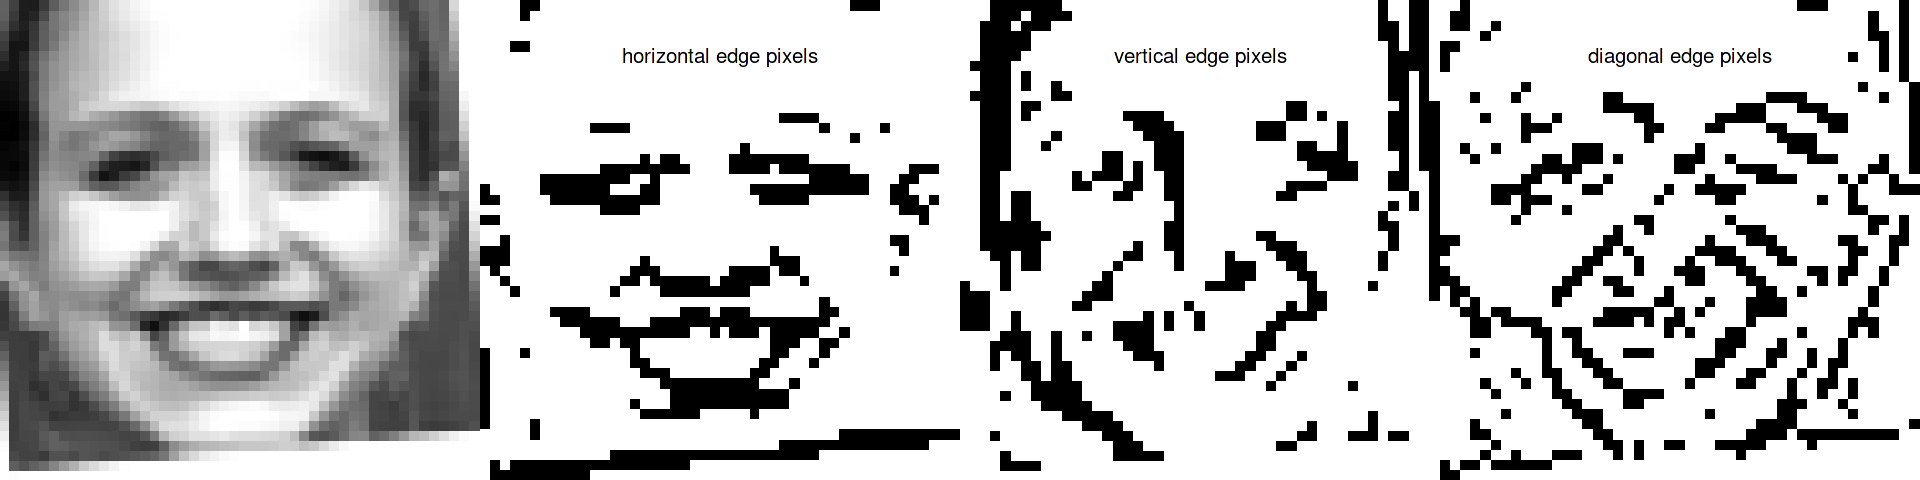

In [9]:
options(repr.plot.width=4*4, repr.plot.height=4)

# Compute edges by differencing neighboring pixels
im = matrix(X_train[756,],48)
h_edge = im[-1,] - im[-48,] # horizontal
v_edge = im[,-1] - im[,-48] # vertical
d_edge = h_edge[,-1] - h_edge[,-48] # diagonal

# Specify a threshold (hand tuned here on visual result)
threshold = .0625 

layout(t(1:4))
as_image(im)
as_image(h_edge < threshold,   47); mtext("horizontal edge pixels")
as_image(v_edge < threshold,   48); mtext("vertical edge pixels")
as_image(d_edge < threshold/2, 47); mtext("diagonal edge pixels")
#as_image((h_edge[,-1] < 0.1) & (v_edge[-1,] < 0.1), 47); mtext("edge pixels")

#### The code for the FreySlateFeatures function is inspired by team 6 of 2020: https://www.kaggle.com/wesselkooy/facial-expression-recognition-team-6-round-2


In [10]:
# Load FreySlateFeatures function 
source("https://bit.ly/32um24j")

# create a edge_features function, from last year's competition, group 10
edge_features = function(X) { 
    
    
# Function to compute edge histogram features
    FeaturesH = tibble()
    FeaturesV = tibble()
    FeaturesD = tibble()
    
# threshold 
    threshold = .0625 
    
    # Create loop
    for (i in 1:nrow(X)) {
        im = matrix(X[i,],48)
        h_edge = im[-1,] - im[-48,] # horizontal
        v_edge = im[,-1] - im[,-48] # vertical
        d_edge = h_edge[,-1] - h_edge[,-48] # diagonal
                
        FeaturesH = bind_rows(FeaturesH, FreySlateFeatures(h_edge < threshold))
        FeaturesV = bind_rows(FeaturesV, FreySlateFeatures(v_edge < threshold))
        FeaturesD = bind_rows(FeaturesD, FreySlateFeatures(d_edge < threshold))

    }

    # change colnames of the data frames
    colnames(FeaturesH) = paste("H",colnames(FeaturesH),sep = "_")
    colnames(FeaturesV) = paste("V",colnames(FeaturesV),sep = "_")
    colnames(FeaturesD) = paste("D",colnames(FeaturesD),sep = "_")
    

    Features_edge = FeaturesH %>% 
    cbind(FeaturesV) %>% 
    cbind(FeaturesD) 
    
    return(Features_edge) 
}

edge_data = edge_features(X_train)

# Histogram of Oriented Gradients (HOG) features

To calculate the HOG features we followed the steps of this website: https://learnopencv.com/histogram-of-oriented-gradients/

Step 2 : Calculate the Gradient Images

In [11]:
# Input: a pixel matrix
# Output: x and y gradient of the image
get_gradients = function(formatted_matrices, size = 48) {   

  add_zeros_column = matrix(rep(0, size), ncol = 1)
  add_zeros_row = matrix(rep(0, size), nrow = 1)
  x_gradient = y_gradient = list()
  
  for(i in 1:length(formatted_matrices)) {
    
    # calculate X gradient
    removed_column = formatted_matrices[[i]][,-size]
    x_gradient[[i]] = formatted_matrices[[i]] - cbind(add_zeros_column, removed_column)
  
    # calculate Y gradient
    removed_row = formatted_matrices[[i]][-1, ]
    y_gradient[[i]] = formatted_matrices[[i]] - rbind(removed_row, add_zeros_row)
    
  }
  return(list(x = x_gradient, y = y_gradient))
}

In [12]:
# Output: matrix of gradient magnitude
gradient_magnitude = function(x_gradient, y_gradient) {
  
  magnitude = list()
  
  for(i in 1:length(x_gradient)) {
    
    magnitude[[i]] = sqrt(x_gradient[[i]]^2 + y_gradient[[i]]^2)
  }
  return(magnitude)
}

In [13]:
# Output: matrix of direction angle
gradient_angle = function(x_gradient, y_gradient) {
  
  radian = angle = list()
  
  # loop over images
  for(i in 1:length(x_gradient)) {
    
    # atan() returns the radian
    radian[[i]] = atan(y_gradient[[i]] / x_gradient[[i]])
    
    # replace NaNs with 0
    radian[[i]][is.na(radian[[i]])] = 0
    
    # conversion to degree: 1 radian = 180/pi (wikipedia)
    angle[[i]] = radian[[i]] * (180/pi)
    
    # add 180 to all pixels < 0
    index = angle[[i]] < 0
    angle[[i]][index] = angle[[i]][index] + 180
  }
  return(angle)
}

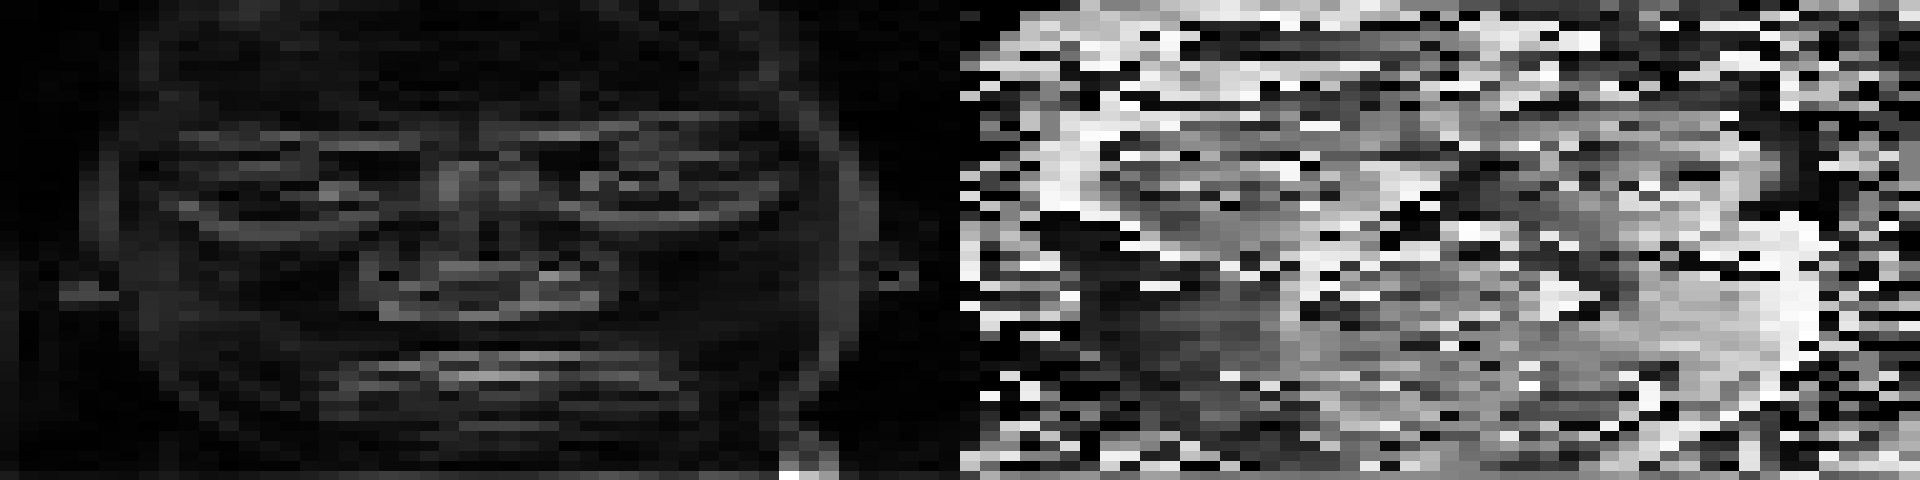

In [14]:
# Visualization of magnitude and angle pixel matrices
image_matrices = format_matrices(X_train)
x_gradient = get_gradients(image_matrices)$x
y_gradient = get_gradients(image_matrices)$y

options(repr.plot.width=4*4, repr.plot.height=4)
layout(t(1:2))
as_image(gradient_magnitude(x_gradient, y_gradient)[[55]]) # right
as_image(gradient_angle(x_gradient, y_gradient)[[55]])     # left

Step 3 : Calculate Histogram of Gradients in 4×4 cells

The gradient matrices (magnitude and angle matrix) are divided into 48 4x4 blocks, 12 blocks per row & column. For each block, a histogram with 9 bins, each with an angle range of 20 is calculated.

The selection of bins was chosen based on method 4 of "Feature Engineering for Images: A Valuable Introduction to the HOG Feature Descriptor"
see: https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/


In [15]:
# Input:  - angle_matrix of 1 image
#         - magnitude_matrix of 1 image
# Output: list of HOG vectors 12 * 12 * 9

get_HOGs_of_blocks = function(angle_matrix, magnitude_matrix) {
  
  upper_limit = seq(20, 160, 20)
  lower_limit = seq(0, 140, 20)
  column = list()
  row_blocks = list()
  
  # separate image into blocks
  pixels = seq(0, 44, by = 4)
  
  # loop over columns in 4*4 blocks
  for(c in pixels){
    
    # loop over rows in 4*4 blocks
    for(r in pixels){ 
      
      angle_block = angle_matrix[(r + 1):(r + 4), (c + 1):(c + 4)]
      magnitude_block = magnitude_matrix[(r + 1):(r + 4), (c + 1):(c + 4)]
      
      # because the intervals are closed to the right the last break point 
      # is set 
      # manually so that values of 180 are included
      bin_index = cut(angle_block, breaks = c(seq(0, 160, 20), 181), 
                       right = FALSE, labels = FALSE)
      bin_index_matrix = matrix(bin_index, 4, 4)
      
      # the bins are emptied for every matrix
      bin = numeric()
      
      for(j in 1:9){
        
        # special case bin 9
        if(j == 9){
          
          # sum(magnitude_vector * ((180 - angle_vector) / 20))
          bin[j] = sum(c(magnitude_block[bin_index_matrix == j]) * 
                    ((180 - c(angle_block[bin_index_matrix == j])) / 20))
          
          # bin_content + sum(magnitude_vector * ((angle_vector - 0) / 20))
          bin[1] = bin[1] + sum(c(magnitude_block[bin_index_matrix == j]) * 
                    ((c(angle_block[bin_index_matrix == j]) - 0)/20))# 0 or 160?
          
          row_blocks[[which(pixels == r)]] <- bin
          column[[which(pixels == c)]] <- row_blocks
          
        }
        
        # sum(magnitude_vector * ((upper_limit - angle_vector)/20))
        bin[j] = sum(c(magnitude_block[bin_index_matrix == j]) * 
                  ((upper_limit[j] - c(angle_block[bin_index_matrix == j])) /
                  20))
        
        
        # sum(magnitude_vector * ((angle_vector - lower_limit)/20))
        bin[j + 1] = sum(c(magnitude_block[bin_index_matrix == j]) * 
                      ((c(angle_block[bin_index_matrix == j]) - lower_limit[j]) 
                       / 20))
      }
    }
  }
  return(column)
}

Step 4 : 8×8 Block Normalization

The 4x4 blocks are concatenated with neighbouring blocks 2x2 across rows and columns. See picture: https://learnopencv.com/histogram-of-oriented-gradients/

#### This function is inspired by team 6 of 2020: https://www.kaggle.com/wesselkooy/facial-expression-recognition-team-6-round-2


In [16]:
# Input: list of 12 * 12 HOG vectors of one image matrix
# Output: list of 11 * 11 HOG vectors of one image matrix
concatenate_block_HOGs = function(blocks) {
  
  concatenated_columns = concatenated_all = list()
  
  # loop over column
  for(i in 1:11) {
    
    # loop over row
    for(j in 1:11){
      
      concatenated_columns[[j]] = unlist(as.vector(c(blocks[[i]][j], blocks[[i]][j + 1],
                                                 blocks[[i + 1]][j], blocks[[i + 1]][j + 1])))
    }
    concatenated_all[[i]] = concatenated_columns
  }
  return(concatenated_all)
}

Step 5 : Calculate the Histogram of Oriented Gradients feature vector

Position of 4x4 blocks: 11 horizontal & 11 vertical positions = 121 positions.
Each 4×4 block is represented by a 36×1 vector.

When concatenating them all into one big vector we obtain a 36×121 = 4356 dimensional vector.

In [17]:
HOG_features = function(train_data){
  
  HOGs_feature_matrix = matrix(0, nrow(train_data), 4356)
  
  # get all image matrices in the right format
  image_matrices = format_matrices(train_data)
  
  # get x & y gradients
  x_gradient = get_gradients(image_matrices)$x
  y_gradient = get_gradients(image_matrices)$y
  
  angle_matrix = gradient_angle(x_gradient, y_gradient)
  magnitude_matrix = gradient_magnitude(x_gradient, y_gradient)
  
  
  for(i in 1:nrow(train_data)) { 
    
    HOGs = get_HOGs_of_blocks(angle_matrix[[i]], magnitude_matrix[[i]])
    
    HOG_feature = concatenate_block_HOGs(HOGs)
    
    HOGs_feature_matrix[i,] = matrix(unlist(HOG_feature), 1, 4356)
  }
  
  return(as.data.frame(HOGs_feature_matrix))
  
}

In [18]:
HOG_features_train_df = HOG_features(X_train)
any(is.na(HOG_features_train_df))
head(HOG_features_train_df)

[1] FALSE

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V4347,V4348,V4349,V4350,V4351,V4352,V4353,V4354,V4355,V4356
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.1753774,0.048642263,0.000000000,0.001309681,0.007843137,0.01290593,0.000000000,0.03874300,0.06815417,1.3522920,⋯,0.22643470,0.004891986,0.01767145,0.00521754,0.03021610,1.295366,0.0000000,0.00000000,0.00000000,0.00000000
2,1.3976058,0.005890482,0.000000000,0.001309681,0.000000000,0.00000000,0.002772968,0.05067974,0.06794914,1.0493726,⋯,0.00000000,0.184313725,0.00000000,0.00000000,0.00000000,2.022485,0.0000000,0.00000000,0.00000000,0.00000000
3,2.2868035,0.000000000,0.000000000,0.001309681,0.058823529,0.00000000,0.052418715,0.07589169,0.19331534,2.8188558,⋯,0.01123473,0.242026578,0.00000000,0.00000000,0.00000000,2.000000,0.0000000,0.00000000,0.00000000,0.02276161
4,0.9903704,0.000000000,1.055322702,0.000000000,1.234158975,0.00000000,0.000000000,0.06066135,0.01134763,0.5759234,⋯,0.04498204,1.048827838,0.03694474,0.00782631,0.52104717,1.101550,0.0000000,0.00000000,0.01253512,0.00000000
5,21.1078113,0.000000000,0.000000000,0.000000000,1.423529412,0.00000000,0.000000000,0.00000000,0.11274206,16.3275997,⋯,0.00000000,2.093298350,0.00000000,0.00260877,0.01706445,1.260663,0.1892281,0.01707658,0.00000000,0.11284056
6,20.6265717,0.000000000,0.008318903,0.003263109,0.925909192,0.00000000,0.000000000,0.00000000,0.32658565,17.3589660,⋯,0.00000000,1.629143687,0.00000000,0.00000000,0.00000000,1.729981,0.6522614,0.17142340,0.12841031,0.17112145


# NZV

Select number of pixels to retain as features and filter NZV predictors of HOG features. 


In [19]:
# Compute P(X > 0)
props = colMeans(X_train > 0)

# Find pixels that are not near-zero-variance
use_pix = props > .075 & props < 1- .075

# What is the number of pixels retained?
sum(use_pix)

[1] 96

In [20]:
getNearZeroVariationPredictors = function(train_df) {
  
  nzv_predictors = train_df %>%
    nearZeroVar(names = TRUE)
  
  if(length(nzv_predictors) == 0) {
    return(0L)  
  } else {
    return(nzv_predictors)
  }
}

nzv = getNearZeroVariationPredictors(HOG_features_train_df)
nzv

nzv_edge = getNearZeroVariationPredictors(edge_data)
nzv_edge

[1] 0

[1] "H_x.box" "H_y.box" "H_width" "H_high"  "V_x.box" "V_y.box" "V_width"
 [8] "V_high"  "D_x.box" "D_y.box" "D_width" "D_high"

In [21]:
getHighCorPredictors = function(train_df) {
  
  high_cor_predictors = train_df %>% 
    select(-all_of(nzv)) %>%
    cor() %>%
    findCorrelation(.95, names = TRUE)
  
  return(high_cor_predictors)
}


high_cor = getHighCorPredictors(HOG_features_train_df)
length(high_cor)
head(high_cor)



high_cor_predictors_edge = edge_data %>% 
    select(-all_of(nzv_edge)) %>%
    cor() %>%
    findCorrelation(.95, names = TRUE)

length(high_cor_predictors_edge)
head(high_cor_predictors_edge)

[1] 3062

[1] "V1279" "V1630" "V1657" "V2035" "V2386" "V2413"

[1] 6

[1] "H_x2ybar" "H_x2bar"  "H_xy2bar" "V_x2ybar" "V_xy2bar" "V_xybar"

In [22]:
clean_train_data = HOG_features_train_df %>%
  select(-all_of(nzv), -all_of(high_cor)) %>%
  as.matrix()

clean_train_data[1:3, 1:5]

clean_edge_data = edge_data %>%
  select(-all_of(nzv_edge), -all_of(high_cor_predictors_edge)) %>%
  as.matrix()

V1,V2,V3,V4,V5
1.175377,0.048642263,0,0.001309681,0.007843137
1.397606,0.005890482,0,0.001309681,0.000000000
2.286803,0.000000000,0,0.001309681,0.058823529


# Merge features

In [23]:
# add pixels as features
pixels_feature_train = X_train[, use_pix]
rownames(pixels_feature_train) <- NULL

train_data = cbind(pixels_feature_train, clean_train_data, clean_edge_data)
train_data[1:3, c(1:3, 97:99)]

p6,p7,p8,V1,V2,V3
0.05490196,0.05882353,0.07450980,1.175377,0.048642263,0
0.03921569,0.03921569,0.04313725,1.397606,0.005890482,0
0.08235294,0.08627451,0.08627451,2.286803,0.000000000,0


In [24]:
# stop if there are any NAs in the data
stopifnot(!any(is.na(train_data)))

In [25]:
# test data
pixels_feature_test = X_test[, use_pix]
rownames(pixels_feature_test) = NULL

HOG_features_test_df = HOG_features(X_test)
any(is.na(HOG_features_test_df))
head(HOG_features_test_df)

edge_test_data = edge_features(X_test)
any(is.na(edge_test_data))
head(edge_test_data)

# remove same features as for train data?
clean_test_data = HOG_features_test_df %>%
  select(-all_of(nzv), -all_of(high_cor)) %>%
  as.matrix()
clean_test_data[1:3, 1:5]

clean_test_edge = edge_test_data %>%
  select(-all_of(nzv_edge), -all_of(high_cor_predictors_edge)) %>%
  as.matrix()

test_data = cbind(pixels_feature_test, clean_test_data, clean_test_edge)
test_data[1:3, c(1:3, 97:99)]

[1] FALSE

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V4347,V4348,V4349,V4350,V4351,V4352,V4353,V4354,V4355,V4356
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.88790572,0.13452379,0.01247835,0.005230127,0.0000000,0.00000000,0.03864107,0.007652155,0.02250142,0.4881551,⋯,0.07929144,0.01665669,0.01338281,0.020797258,0.01452572,1.327271,0.00000000,0.00000000,0.00000000,0.00000000
2,0.97452324,0.00000000,0.00000000,0.012492986,0.0000000,0.00000000,0.02992787,0.018313714,0.05670800,1.0985770,⋯,0.00000000,0.38823529,0.00000000,0.000000000,0.00000000,2.521533,0.00000000,0.00000000,0.00000000,0.00000000
3,4.00000000,0.00000000,0.00000000,0.000000000,0.1352941,0.00000000,0.00000000,0.000000000,0.00000000,0.3621369,⋯,0.00000000,0.00000000,0.00000000,0.011974401,0.01583540,1.197660,0.02156294,0.01423778,0.01255689,0.00000000
4,0.48289168,0.07100379,1.15504898,0.000000000,1.4313725,0.00000000,0.04612259,0.005756824,0.02261110,1.8149824,⋯,0.00000000,1.13038218,0.00000000,0.006735194,0.57916254,1.343565,0.00000000,0.00000000,0.00000000,0.00000000
5,0.80504247,0.04990795,1.24284954,0.346027349,1.0627451,0.00000000,0.00000000,0.020148883,0.06808578,0.8812244,⋯,0.00000000,0.99215686,0.00000000,0.000000000,0.00000000,2.272233,0.00000000,0.00000000,0.00000000,0.00000000
6,0.06427768,0.00000000,1.00096436,0.031213397,0.4238002,0.01165933,0.02592404,0.018278991,0.00000000,2.1806747,⋯,0.01143067,0.24202658,0.00000000,0.000000000,0.00000000,2.555297,0.00000000,0.09104303,0.00000000,0.02276161


[1] FALSE

,H_x.box,H_y.box,H_width,H_high,H_onpix,H_x.bar,H_y.bar,H_x2bar,H_y2bar,H_xybar,⋯,D_y.bar,D_x2bar,D_y2bar,D_xybar,D_x2ybar,D_xy2bar,D_x.ege,D_xegvy,D_y.ege,D_yegvx
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7.978723,8.138298,14.68085,15,12.57583,7.295478,7.463175,3.619980,3.779167,3.670657,⋯,7.290934,3.620265,3.619075,3.592564,1.757752,1.757731,16.00000,17.89271,13.86364,23.00589
2,7.978723,8.138298,14.68085,15,12.65052,7.268894,7.469502,3.620587,3.778740,3.670555,⋯,7.288777,3.620260,3.619240,3.592697,1.757752,1.757750,15.40541,19.05387,14.20455,21.60706
3,7.978723,8.138298,14.68085,15,12.71842,7.270960,7.463973,3.620629,3.778712,3.671071,⋯,7.291990,3.619183,3.618804,3.592852,1.757759,1.757756,11.07143,13.56722,12.77778,17.34948
4,7.978723,8.138298,14.68085,15,12.75238,7.290288,7.478161,3.619987,3.779358,3.670455,⋯,7.287384,3.619838,3.619427,3.592699,1.757746,1.757744,13.92857,20.54097,13.45238,21.57311
5,7.978723,8.138298,14.68085,15,12.72522,7.272729,7.469520,3.620320,3.778952,3.670527,⋯,7.276124,3.619079,3.618959,3.592171,1.757746,1.757771,12.73810,21.47125,13.21429,17.83160
6,7.978723,8.138298,14.68085,15,12.39249,7.262119,7.463689,3.619486,3.778851,3.670305,⋯,7.281508,3.619350,3.619001,3.592649,1.757751,1.757786,10.54348,17.40380,11.77778,20.13354


V1,V2,V3,V4,V5
0.8879057,0.1345238,0.01247835,0.005230127,0.0000000
0.9745232,0.0000000,0.00000000,0.012492986,0.0000000
4.0000000,0.0000000,0.00000000,0.000000000,0.1352941


p6,p7,p8,V1,V2,V3
0.03921569,0.05490196,0.08235294,0.8879057,0.1345238,0.01247835
0.04313725,0.04313725,0.04705882,0.9745232,0.0000000,0.00000000
0.07450980,0.03529412,0.03529412,4.0000000,0.0000000,0.00000000


# Fit a model

To figure out which model provides the best trade off between bias and variance, between accuracy and flexibility, one strategy is to fit both a flexible and a more rigid model and determine from CV error which direction on the flexiblity axis we should go to avoid overtraining.

We are starting with Lasso and Ridge as model fits. We have a lot of variables in the data because we ause all the pixels as predictors so we think lasso might have a good fit on the dataset.

We also consider classification trees and random forests here. Random forests are probably the least susceptible to overtraining and is considered one of the best "off the shelf" machine learning algorithms in the sense that they require little expertise in application.

After the the trees we look at LDA and knn/knns and see how they perform trying to classify the da



# Splitting up the data
Idea taken from group 9: Using a funtion to split up the data train into a test and train set to gain a better insight in the accuracy of the model in the model comparison at the end.

In [26]:
TrainIndex = caret::createDataPartition(y, p = 0.8, list = FALSE)


## Lasso Regression

In [27]:
# Fit a CART using 5-fold cross-validation to tune the complexity parameter
trCntrl = trainControl('cv', 5, allowParallel = TRUE)

lasso_fit = train(train_data[TrainIndex,], y[TrainIndex], 
                  method = 'glmnet', trControl = trCntrl,
                  tuneGrid = expand.grid(alpha = 1, lambda = 0.004))

lasso_fit

glmnet 

2032 samples
1420 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1626, 1625, 1624, 1626, 1627 
Resampling results:

  Accuracy   Kappa    
  0.9188072  0.8882475

Tuning parameter 'alpha' was held constant at a value of 1
Tuning
 parameter 'lambda' was held constant at a value of 0.004

## Ridge Regression

In [28]:
## Check performance on training set
ridge_fit <- train(train_data[TrainIndex,], y[TrainIndex], 
                   method = 'glmnet', trControl = trCntrl,
                   tuneGrid = expand.grid(alpha = 0, lambda = 0.002))

ridge_fit

glmnet 

2032 samples
1420 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1626, 1626, 1624, 1626, 1626 
Resampling results:

  Accuracy   Kappa    
  0.9458683  0.9255148

Tuning parameter 'alpha' was held constant at a value of 0
Tuning
 parameter 'lambda' was held constant at a value of 0.002

## Classification Tree

Here we fit a classification tree, using the pixel based approach.

In [29]:
suppressMessages(require(caret))
# Use multiple cores whenever possible
library(parallel)
suppressMessages(library(doParallel))
(detectCores() - 1) %>% makeCluster() %>% registerDoParallel()

fit_tree = train(x = train_data[TrainIndex,], y = y[TrainIndex], method = 'rpart', trControl = trCntrl, tuneGrid = data.frame(cp = .02))
fit_tree

CART 

2032 samples
1420 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1625, 1626, 1626, 1625, 1626 
Resampling results:

  Accuracy   Kappa   
  0.5925104  0.433057

Tuning parameter 'cp' was held constant at a value of 0.02

# LDA

Variables 1415 and 1416 had to be removed for the lda because they appeared to be constant within groups. That is why a new dataset for lda is created.

In [30]:
# Fitting classifier models from ISLR Chapter 4
trcntr = trainControl('cv', number = 5, p = .8)

# Creating one dataset to fit the other models on
head(train_data)[,1415:1416]
data_lda = train_data %>%
           as.tibble() %>%
           select(-c(D_x2ybar, D_xy2bar))

# Fitting the lda model
lda_fit = caret::train(y = y[TrainIndex], x = data_lda[TrainIndex,],
                            method = 'lda',
                            trControl = trcntr)
lda_fit

D_x2ybar,D_xy2bar
1.757745,1.757724
1.757727,1.757750
1.757744,1.757751
1.757754,1.757746
1.757747,1.757717
1.757753,1.757722


Warning message:
“`as.tibble()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“Setting row names on a tibble is deprecated.”


Linear Discriminant Analysis 

2032 samples
1418 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1626, 1627, 1625, 1626, 1624 
Resampling results:

  Accuracy   Kappa    
  0.7130775  0.6081665


# KNN/KNNs



In [31]:
# KNN
fit_knn = caret::train(y = y[TrainIndex], 
                       x = train_data[TrainIndex,],
                       method = 'knn',
                       trControl = trcntr)
fit_knn

k-Nearest Neighbors 

2032 samples
1420 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1625, 1626, 1625, 1626, 1626 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.5000085  0.3056441
  7  0.4827695  0.2789582
  9  0.4886808  0.2834717

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.

In [32]:
# KNNS
fit_knns = caret::train(y = y[TrainIndex],
                        x = train_data[TrainIndex,],
                        method = 'knn',
                        trControl = trcntr, 
                       preProcess = "scale")
fit_knns

k-Nearest Neighbors 

2032 samples
1420 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

Pre-processing: scaled (1420) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1626, 1625, 1626, 1625, 1626 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.7101233  0.5996029
  7  0.6992944  0.5836399
  9  0.6914283  0.5714920

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.

# Support vector machine

In [33]:
tune_svm = e1071::tune.svm(y ~., 
                       data = data.frame(train_data[TrainIndex,], y = as.factor(y[TrainIndex])), 
                       kernel = 'radial',
                       gama = c(0.5,1,2,3,4),
                       range = list(cost = c(0.001,0.01,0.1,1,5,10)))


tune_svm$best.model # The best cost is 1 so we chose cost = 1 for the model

fit_svm = e1071::svm(y~., data = data.frame(train_data[TrainIndex,], y = as.factor(y[TrainIndex])), cost = 1, 
                scale = TRUE, kernel = 'radial')


Call:
best.svm(x = y ~ ., data = data.frame(train_data[TrainIndex, ], y = as.factor(y[TrainIndex])), 
    kernel = "radial", gama = c(0.5, 1, 2, 3, 4), range = list(cost = c(0.001, 
        0.01, 0.1, 1, 5, 10)))


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  1777


# Model Comparison


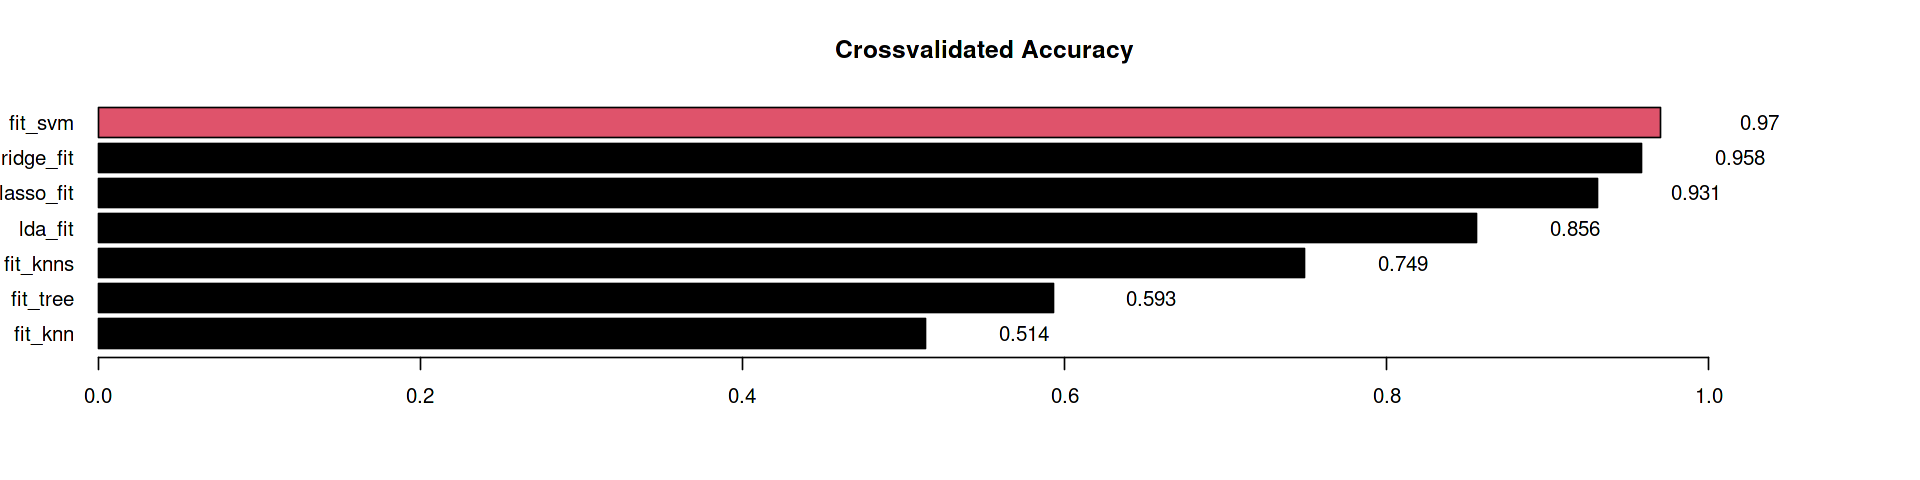

In [34]:
# list of the fitted models
models = list(ridge_fit = ridge_fit,
              lasso_fit = lasso_fit,
              fit_tree = fit_tree, 
              lda_fit = lda_fit,
              fit_knn = fit_knn, 
              fit_knns = fit_knns,
              fit_svm = fit_svm)  

# extract the cross-validated accuracies from each model
predictions = sapply(models, function(x) predict(x, train_data[-TrainIndex,], type='raw')) 
Acc = colMeans(predictions == y[-TrainIndex]) %>% sort()              

# make a barplot with accuracy shown: inspired by group 9
plot = barplot(Acc, col = (Acc == max(Acc))+1, 
horiz = TRUE, las=1, xlim = c(0,1.1), main = "Crossvalidated Accuracy")
text(Acc + strwidth("__0.000"), plot, round(Acc,3))

# The Final Model

We crossvalidated the data into a 80/20 split to see which model would perform best on our created testset. Both the ridge model and the svm model had a very high prediction accuracy with the support vector machine model coming out on top. Ridge regression and support vector machines are very closely related to one another so seeing them so close to each other makes sense. Lasso was 3rd best in prediction accuracy. After lasso the accuracy of the other models were quit a bit lower. We think that the ridge regression model and the support vector machines will perform very similar on the real testset but the support vector machines will probably perform a bit better. Also because the support vector machine model is more flexible model compared to the ridge regression model. Therefore our final model is the support vector machine model.

## The bias variance trade off
- While ridge regression is a model that is sensitive to more variance but minimizes bias, the lasso regression is more sensitive to bias and tries to minimize variance. Interesting to see is that in this case the ridge regression outperformed the lasso regression even though a lot of variables were introduced to the models.
- While lasso and ridge regression are models that are less flexible but highly interpretable, the support vector machine model is the opposite. the svm model is difficult to understand but in this case we want the prediction accuracy to be as high as possible so we are less interested in the interpretability of the model. The support vector machine model has low bias and high variance, just like the ridge regression. The trade-off between between bias and variance can be changed by increasing the C parameter (which we optimised at 1).
- We can conclude from our model comparison that models that had low bias and high variance (ridge and svm) outperformed models that had a high bias and a low variance (lasso, lda) on this dataset. 

# Formatting your submission file

To format your submission file,we first have to run our final model on the whole trainigset. After that the predictions on the testset are made.

In [35]:
fit_svm_final = e1071::svm(y~., data = data.frame(train_data, y = as.factor(y)), cost = 1, 
                scale = TRUE, kernel = 'radial')
pred_svm = predict(fit_svm_final, test_data, type = "raw")

In [36]:
# Write to file
tibble(file = rownames(X_test), category = as.vector(pred_svm)) %>% 
    write_csv(path = "submission.csv")

## Check result
cat(readLines("submission.csv",n=20), sep="\n")

Warning message:
“The `path` argument of `write_csv()` is deprecated as of readr 1.4.0.
Please use the `file` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


file,category
S010_004_00000017a.png,anger
S010_004_00000017b.png,anger
S010_004_00000017c.png,anger
S010_004_00000017d.png,anger
S010_004_00000017e.png,disgust
S010_004_00000017f.png,anger
S011_002_00000022a.png,sad
S011_002_00000022b.png,sad
S011_002_00000022c.png,sad
S011_002_00000022d.png,sad
S011_002_00000022e.png,sad
S011_002_00000022f.png,sad
S011_005_00000018a.png,disgust
S011_005_00000018b.png,disgust
S011_005_00000018c.png,disgust
S011_005_00000018d.png,disgust
S011_005_00000018e.png,disgust
S011_005_00000018f.png,disgust
S011_006_00000013a.png,happy


# Division of labor
- Getting started with the first model and prediction: Jessica, Zena, Thomas
- Creating the first lasso model: Jessica, Zena, Thomas
- Creating the hog features: Jessica
- Creating the FreySlateFeatures: Zena
- Creating different models and model comparison: Thomas
- Add the svm model: Jessica, Zena
- Making the model comparison work: Jessica, Thomas
- Final remarks about chosen model and bias variance trade off: Thomas